### Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


### Loading human detection training data

In [3]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = int(imgname[8:12])
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [4]:
# Check number of human dectection samples.
nData = 0
nFrame = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
        nFrame += 1
nData, nFrame

(1607, 420)

### Training CNN with human images

In [5]:
# Save clips 
path = 'videos/'
frames = {}
H, W = 480, 720

frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)    
    frames[iClip] = []
    for iFrame in bbox[iClip]:
        if iFrame > 1:
            cap.set(1, iFrame-10)
            ret, frame = cap.read()
            if ret:
                frames[iClip].append(torch.from_numpy(frame))
            cap.set(1, iFrame)
            ret, frame = cap.read()
            if ret:
                frames[iClip].append(torch.from_numpy(frame))


100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


In [6]:
# Training samples
X_sample = torch.zeros(nData*2,3,29,15)
y_sample = torch.zeros(nData*2, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        if iFrame > 1:
            for d in bbox[iClip][iFrame]:
                if type(d)==np.ndarray:
                    w, h, _, _ = d
                    data = frames[iClip][int(iFrame/200)*2-1][h:h+29, w:w+15, :].to(dtype=torch.float32)
                    X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
                    y_sample[i] = 1
                    i += 1
while i < nData*2:
    iClip = random.choice(list(bbox.keys()))
    k, h, w = random.randint(1,40), random.randint(0,H-30), random.randint(0, W-15)
    data = frames[iClip][k][h:h+29, w:w+15, :].to(dtype=torch.float32)
    X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
    i += 1

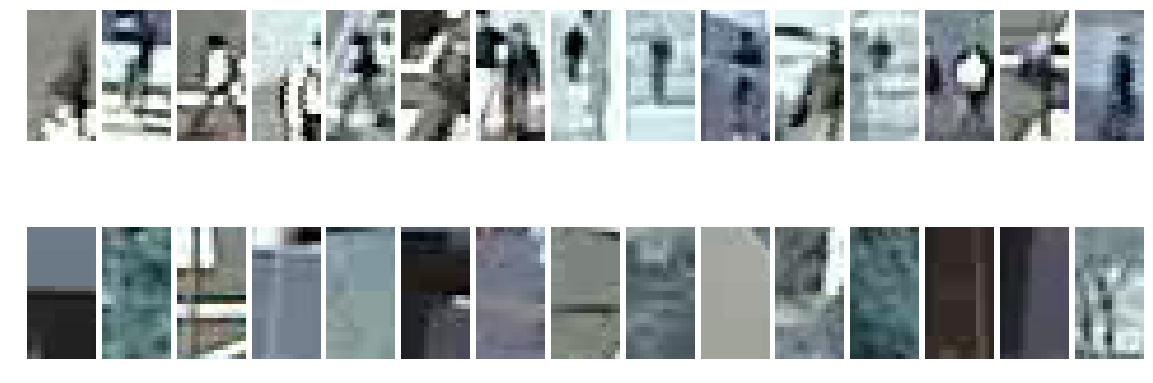

In [7]:
fig = plt.figure(figsize=(20,8))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

fig.subplots_adjust(wspace=0.1, hspace=0)

In [8]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    train_acc = []
    val_acc = []
    for e in tqdm(range(epochs)):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            if t % 1000 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_acc.append(100.*check_accuracy(X_train, y_train, model))
                val_acc.append(100.*check_accuracy(X_val, y_val, model))
                print()
            
            t += 1
    check_accuracy(X_train, y_train, model)
    check_accuracy(X_val, y_val, model)
                
#     plt.plot(list(range(1,int(t/1000)+1)), train_acc, label='train')
#     plt.plot(list(range(1,int(t/1000)+1)), val_acc, label='val')
#     plt.title('Classification accuracy history')
#     plt.xlabel('Iteration')
#     plt.ylabel('Clasification accuracy')
#     plt.legend()
#     plt.show()

In [9]:
# Train CNN
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(),
    nn.Dropout(),
    Flatten(),
    nn.Linear(16*15*29, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 2),
)

In [10]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

optimizer = optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 0, loss = 0.6327
Got 1359 / 2571 correct (52.86)
Got 369 / 643 correct (57.39)



 30%|███       | 3/10 [00:05<00:12,  1.75s/it]

Iteration 1000, loss = 0.1439
Got 2175 / 2571 correct (84.60)


 40%|████      | 4/10 [00:08<00:13,  2.17s/it]

Got 530 / 643 correct (82.43)



 70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

Iteration 2000, loss = 2.1765
Got 2335 / 2571 correct (90.82)


 80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

Got 570 / 643 correct (88.65)



100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Got 2364 / 2571 correct (91.95)
Got 574 / 643 correct (89.27)


### Generating region proposal

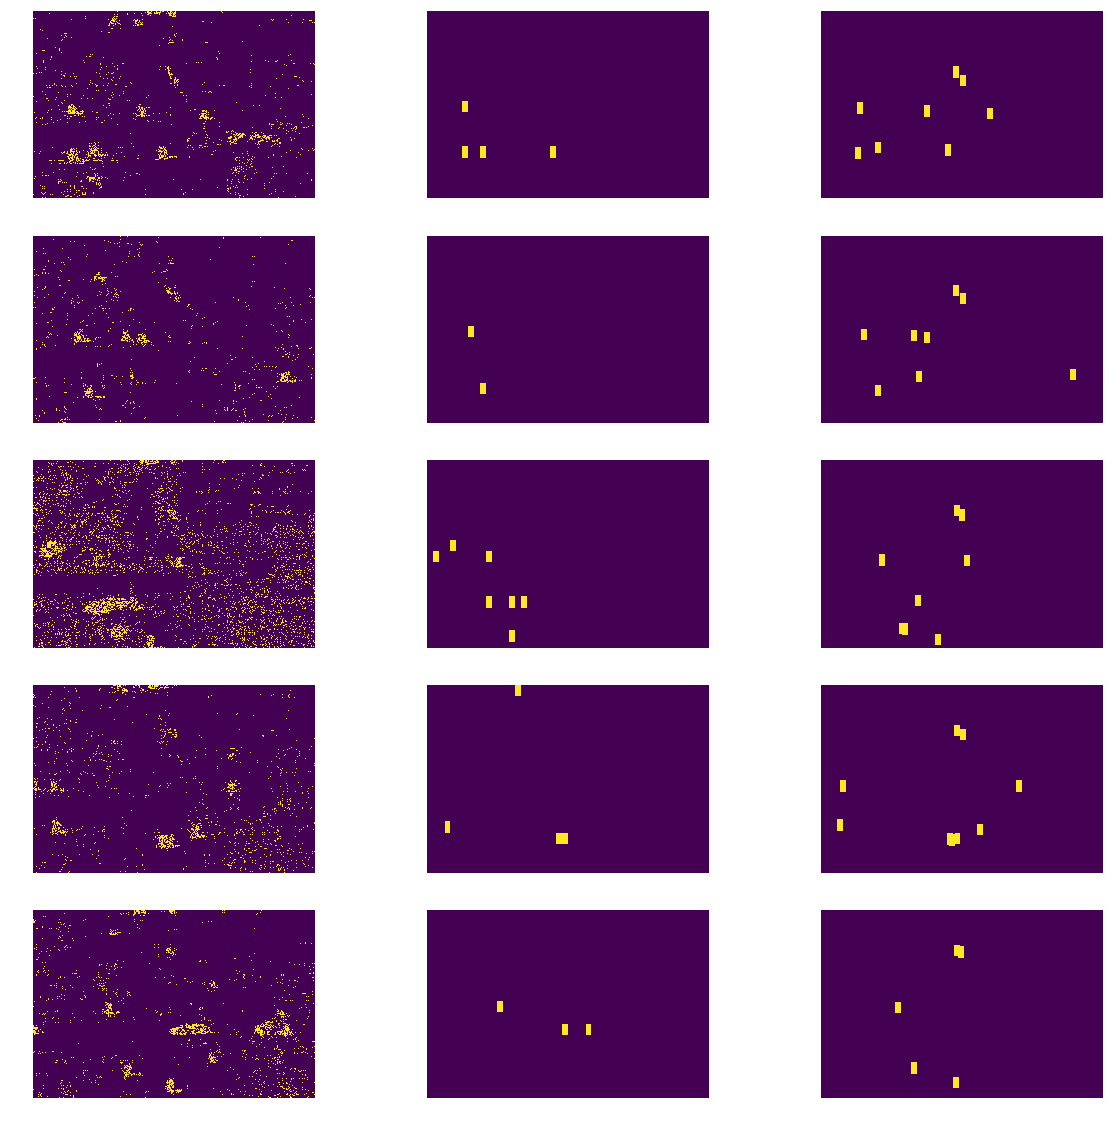

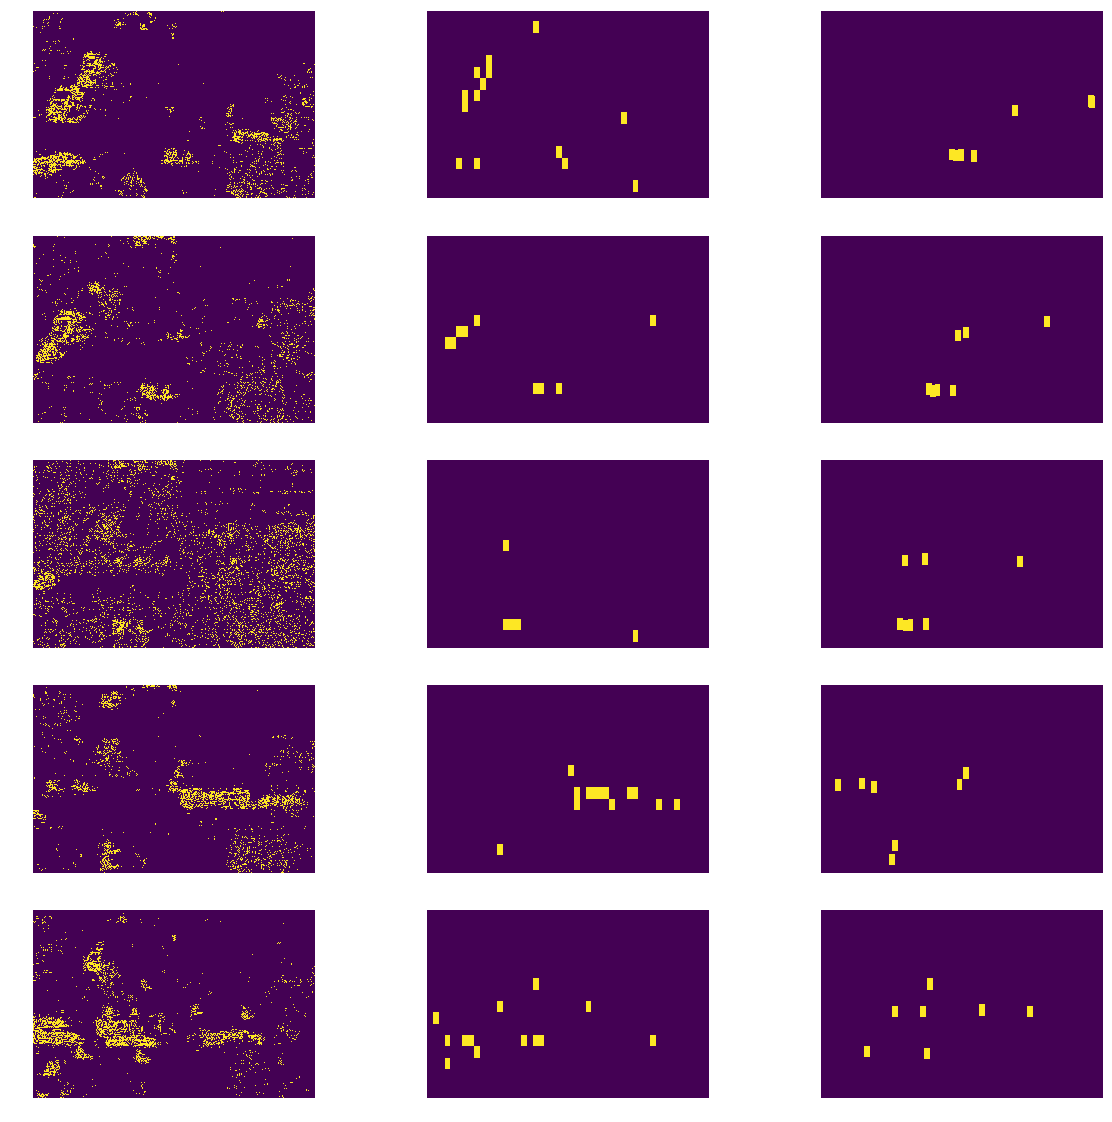

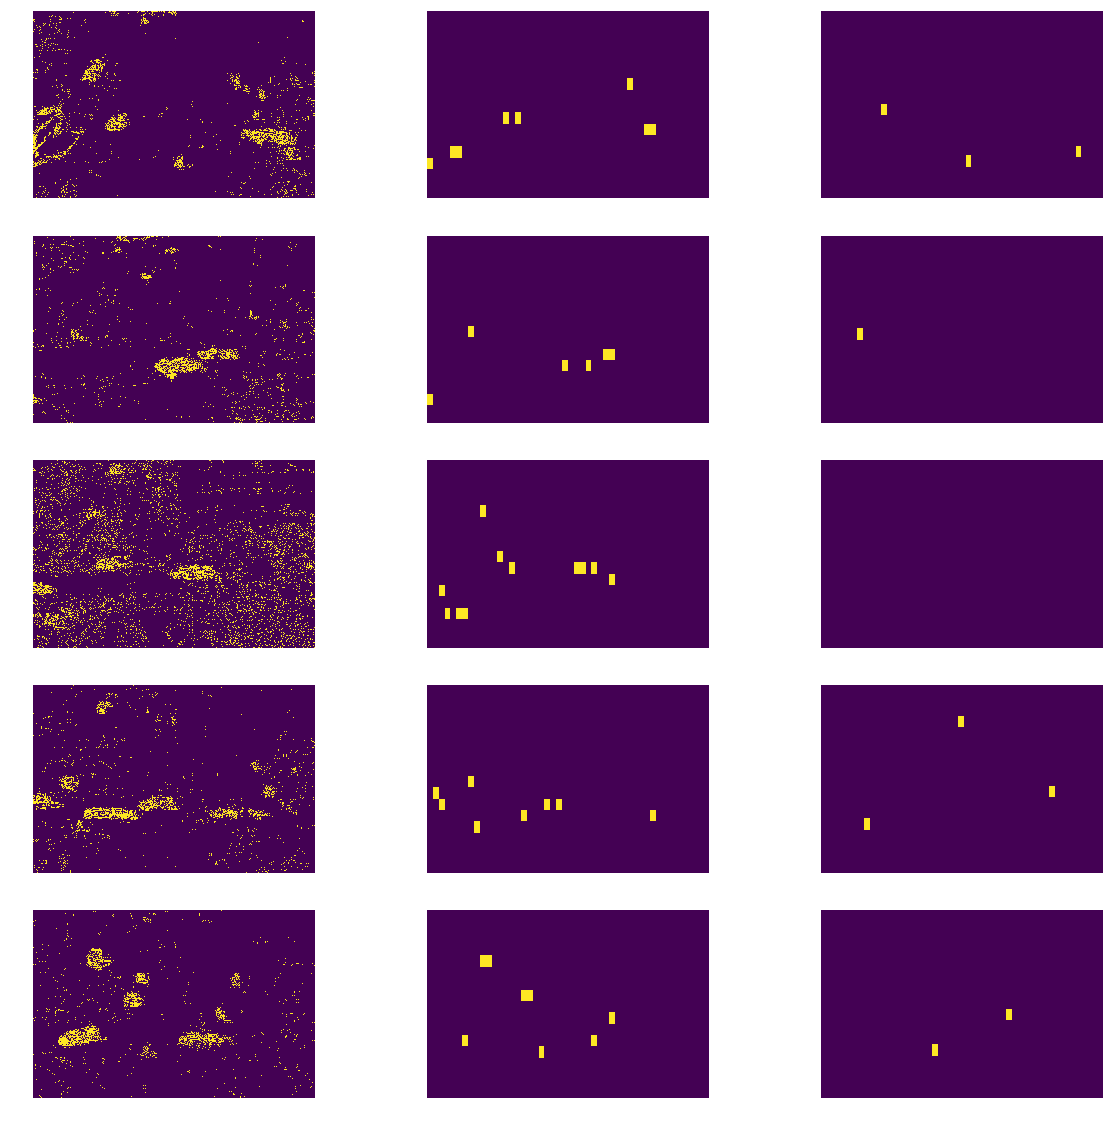

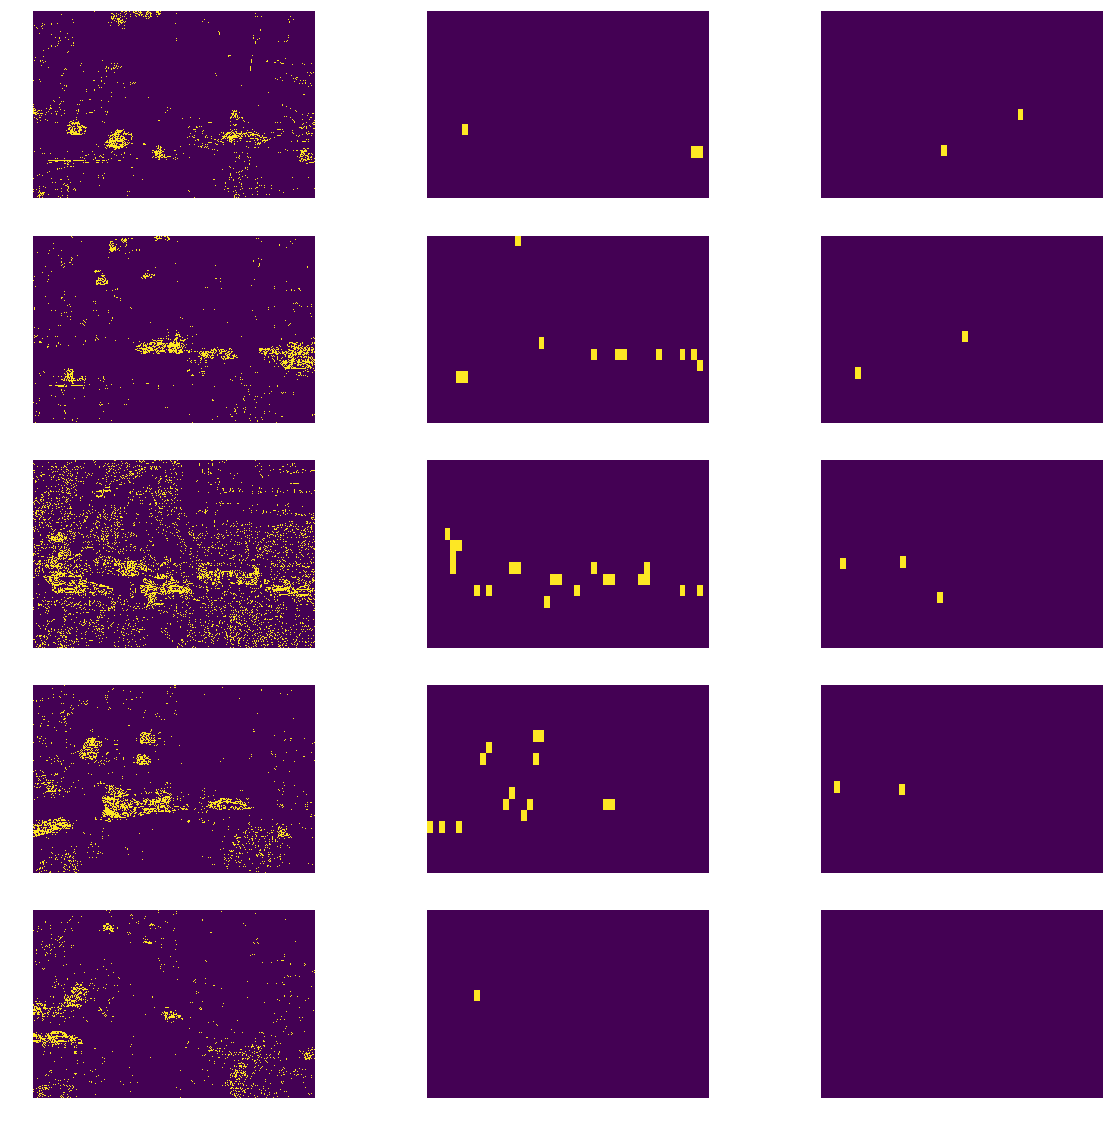

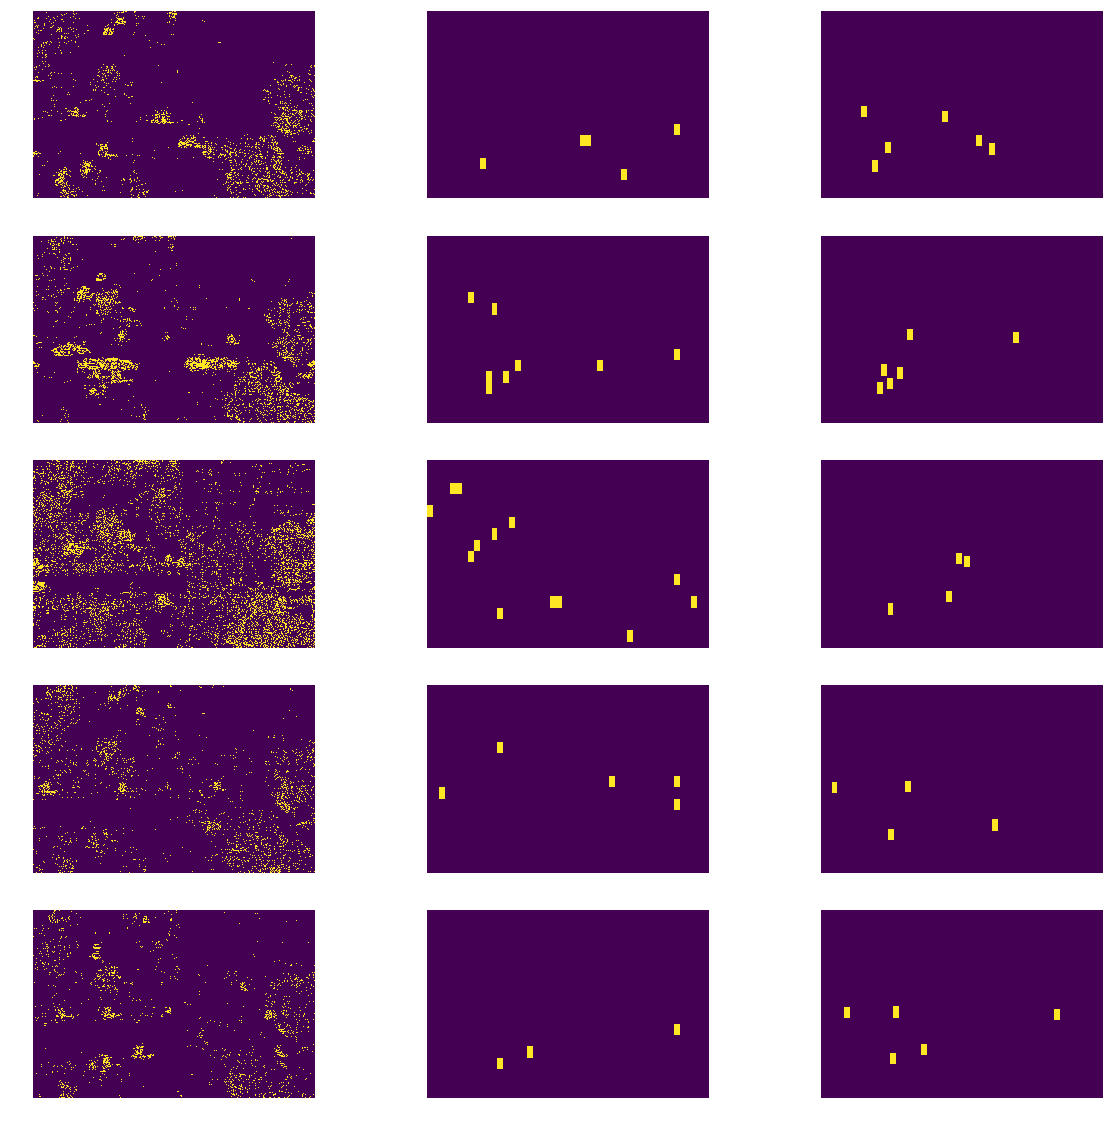

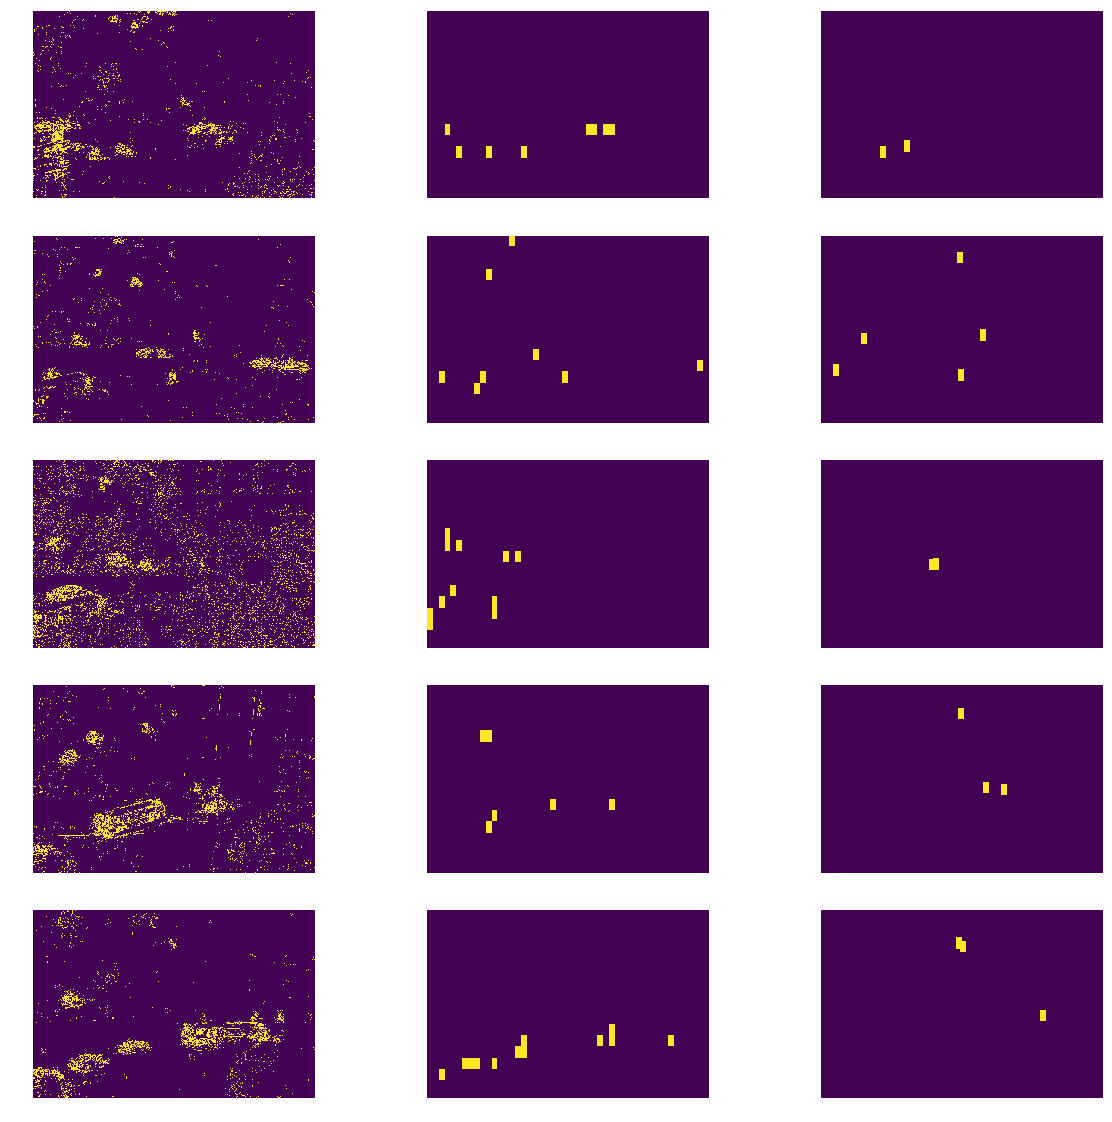

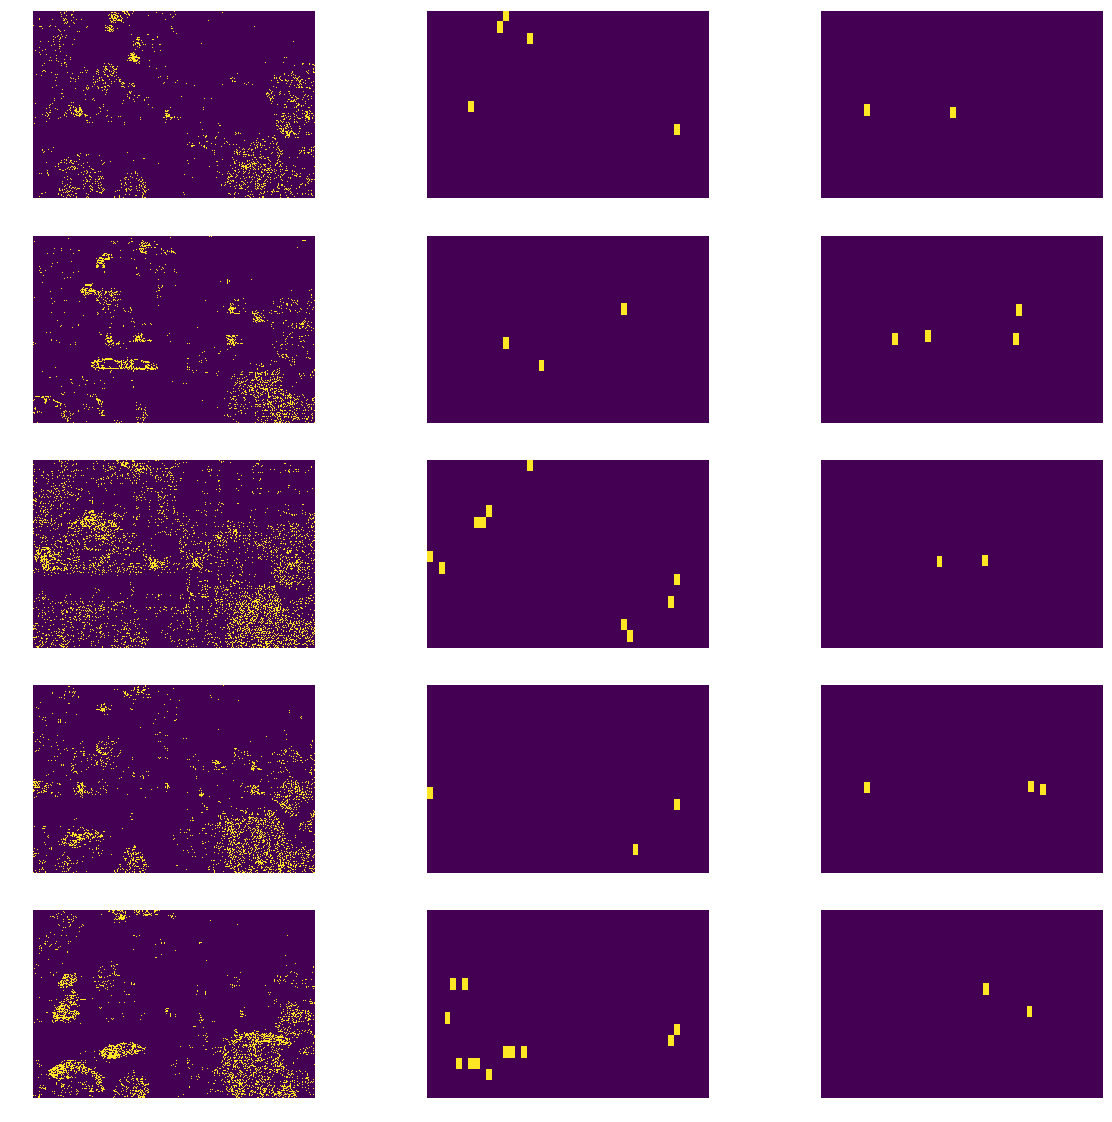

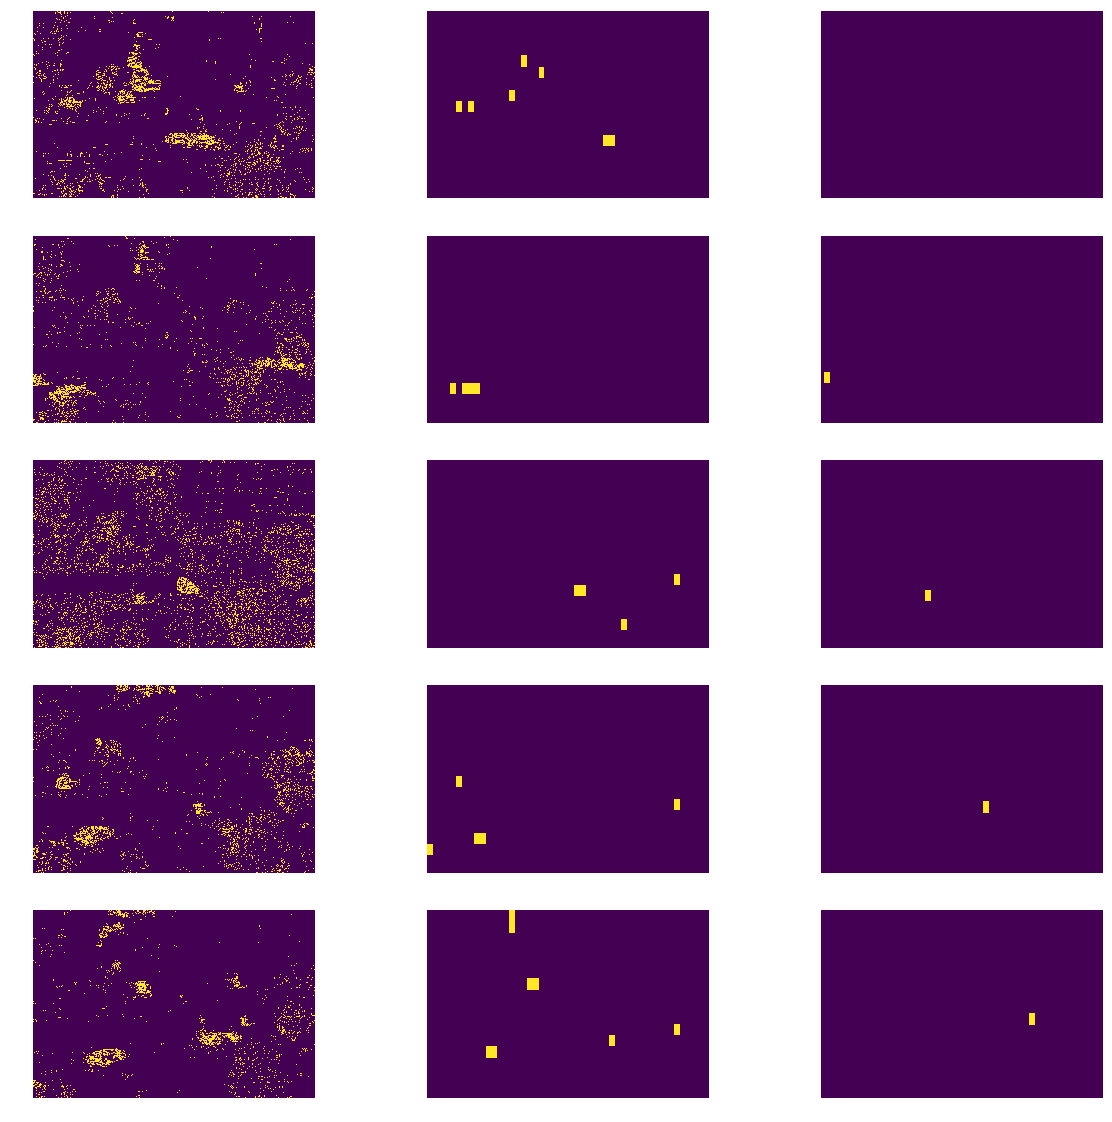

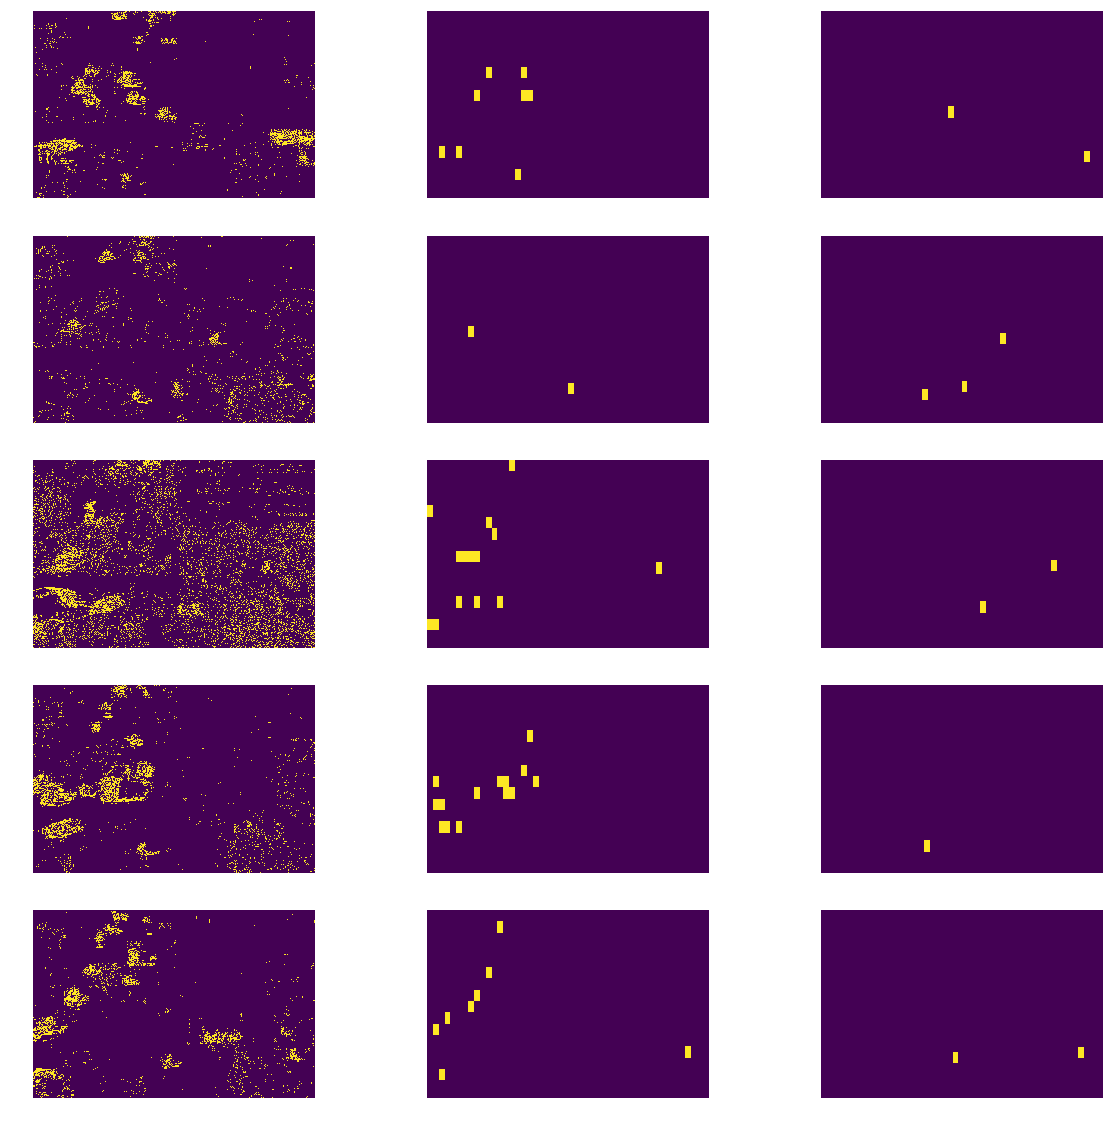

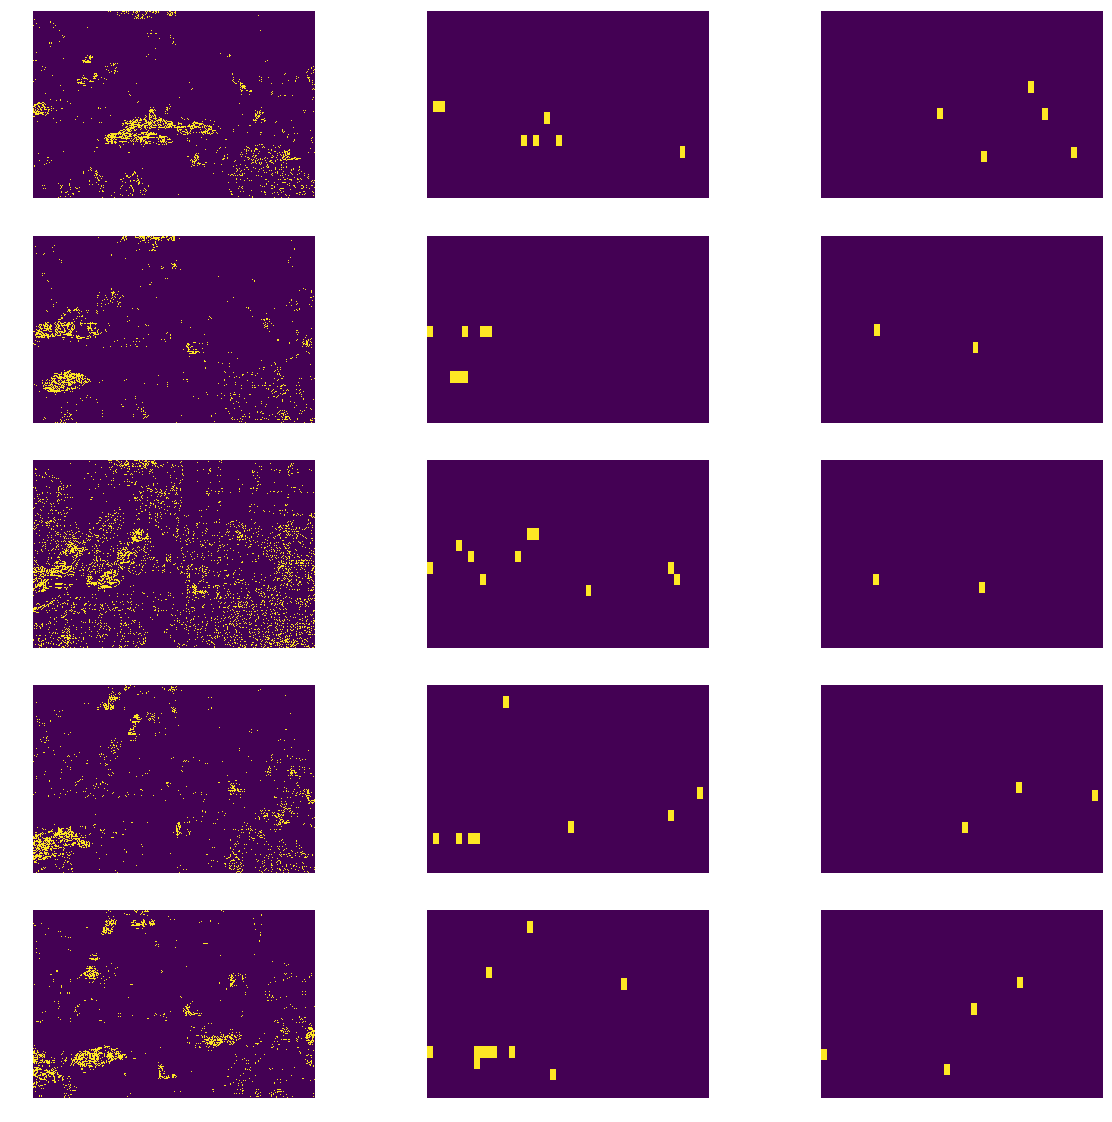

In [15]:
# Check displacement between frames
for iClip in frames:
    fig = plt.figure(figsize=(20,20))
    for i in range(5):
        frame = frames[iClip][i*2+1]
        frame_prev = frames[iClip][i*2]
        X_diff = abs(frame[:,:,0] - frame_prev[:,:,0])
        X_diff += abs(frame[:,:,1] - frame_prev[:,:,1])
        X_diff += abs(frame[:,:,2] - frame_prev[:,:,2])
        X_diff /= 3
        X_diff = (X_diff < 60) & (X_diff > 10)
        ax = fig.add_subplot(5,3,3*i+1)
        ax.axis('off')
        ax.imshow(X_diff.to(dtype=torch.uint8))
    
        cand = []
        for h in range(0, H-30, 29):
            for w in range(0, W-15, 15):
                x = X_diff[h:h+29, w:w+15]
                if x.sum() > 100:
                    x_frame = frame[h:h+29, w:w+15, :]
                    scores = model(x_frame.permute(2,0,1).unsqueeze(0).to(device=device, dtype=dtype))
                    if scores[0][0] < scores[0][1]:
                        cand.append((h, w))
        
        tmp = torch.zeros(H,W)
        for h, w in cand:
            tmp[h:h+29, w:w+15] = 1
            
        tmp2 = torch.zeros(H,W)
        for d in bbox[iClip][i*200+201]:
            if type(d)==np.ndarray:
                w, h, _, _ = d
                tmp2[h:h+29, w:w+15] = 1
    
        ax = fig.add_subplot(5,3,3*i+2)
        ax.axis('off')
        ax.imshow(tmp.to(dtype=torch.uint8))
        
        ax = fig.add_subplot(5,3,3*i+3)
        ax.axis('off')
        ax.imshow(tmp2.to(dtype=torch.uint8))
        

AttributeError: 'Figure' object has no attribute 'close'